#Info
 This notebook includes: 


*   managing the [SeriesDescription] null values at Dicom_info.csv.
*   merging some CSV files.
*   dropping some unnecessary columns.
*   the results are extracted to drive directory





In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"
dicom_info = pd.read_csv(f'{DDSM_dir}/csv/dicom_info.csv')
dicom_info.info()

dicom_info['image_path'] = dicom_info.image_path.apply(lambda x: x.replace('CBIS-DDSM', DDSM_dir))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

#Ploting all null image types


we have 566 images which does'nt have type 

In [ ]:
null_rows = dicom_info[dicom_info.SeriesDescription.isnull()]
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 4 to 10204
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    566 non-null    object 
 1   image_path                                   566 non-null    object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                566 non-null    int64  
 4   BitsStored                                   566 non-null    int64  
 5   BodyPartExamined                             566 non-null    object 
 6   Columns                                      566 non-null    int64  
 7   ContentDate                                  566 non-null    int64  
 8   ContentTime                                  566 non-null    float64
 9   ConversionType                               566 non-null    object 
 10  

100%|██████████| 566/566 [01:13<00:00,  7.68it/s]


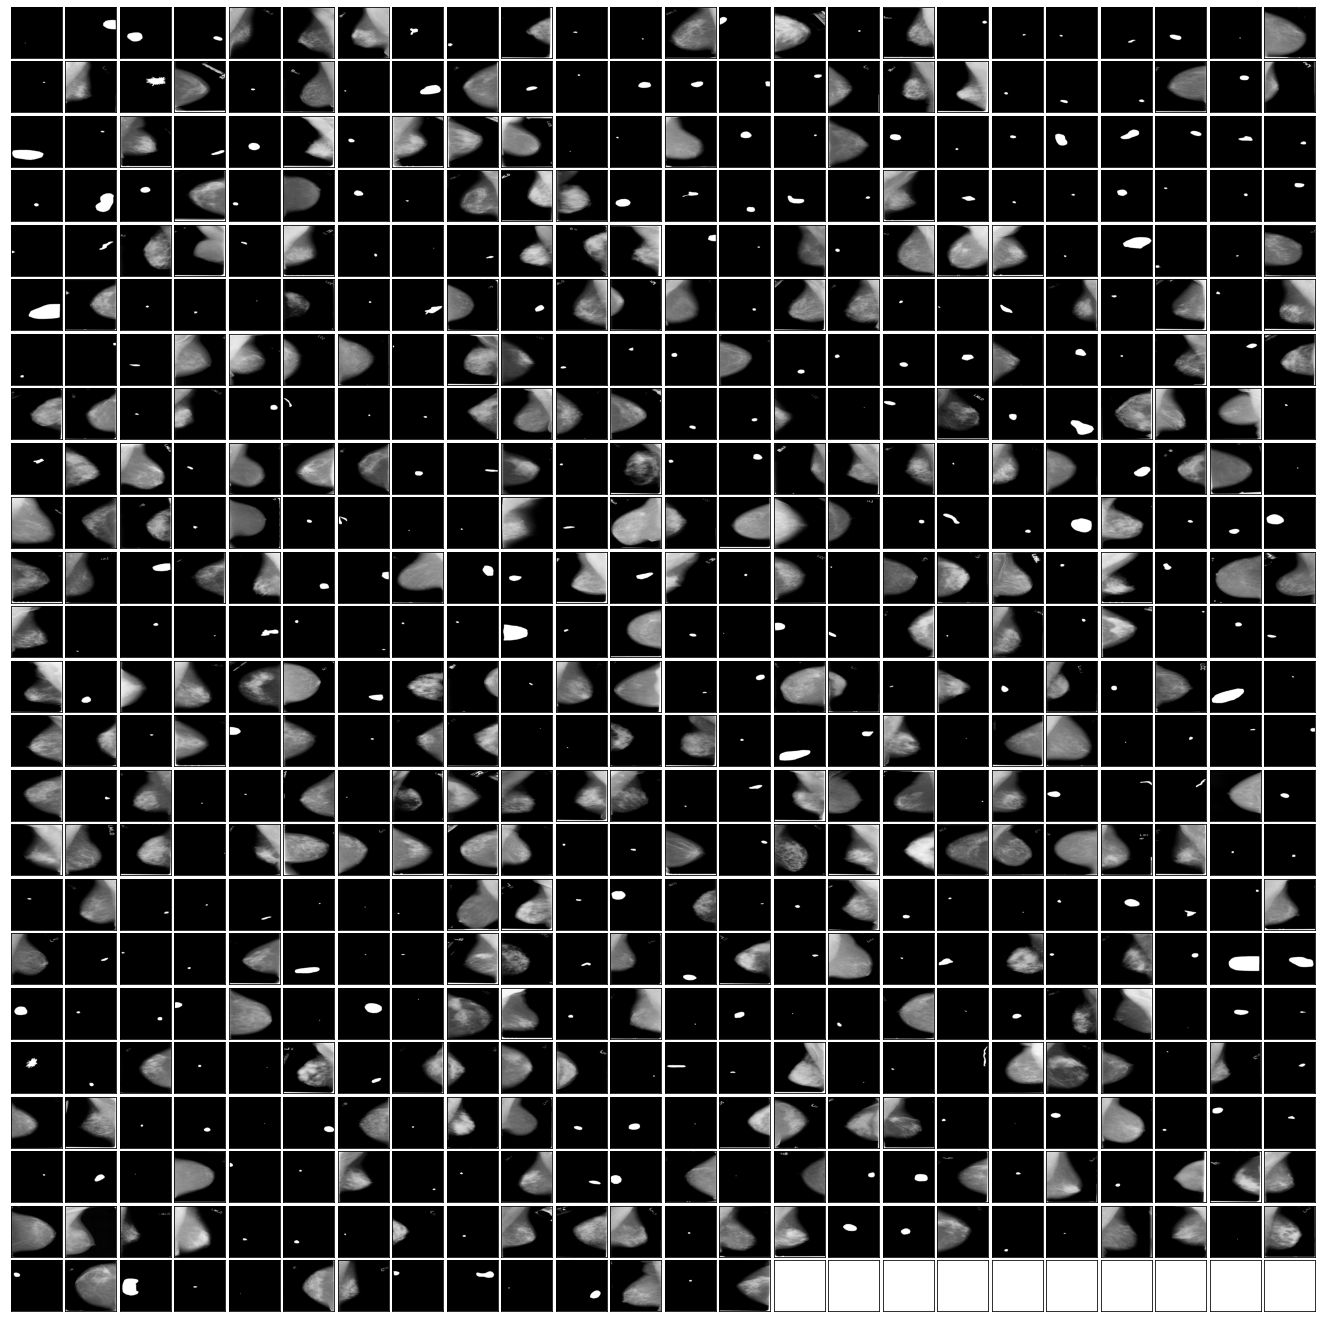

In [ ]:
#function definition 
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import cv2
import math

def plotImages(Files):

  images     = []
  for image_path in tqdm(Files):
    img = cv2.resize(cv2.imread(image_path), dsize=(512,512))
    images.append(img)

  n = math.ceil(math.sqrt(len(images)))
  fig = plt.figure(figsize=(n, n))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
  for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
  plt.show()

plotImages(null_rows.image_path)

#Resolving image type null values


usually the number of black pixels is higher in the ROI format.

to resolve the null values , we created a loop to compare the number of black pixels to total number of pixels in an image




In [ ]:
for idx in tqdm(null_rows.index):
  image = null_rows.at[idx,'image_path']
  img = cv2.imread(image)
  number_pixel = img.size
  number_of_black_pix = np.sum(img == 0)
  if (number_of_black_pix > number_pixel/1.2): # try and error
    null_rows.at[idx,'SeriesDescription'] = 'ROI mask images'
  else:
    null_rows.at[idx,'SeriesDescription'] = 'full mammogram images'


100%|██████████| 566/566 [01:55<00:00,  4.92it/s]


100%|██████████| 245/245 [00:41<00:00,  5.91it/s]


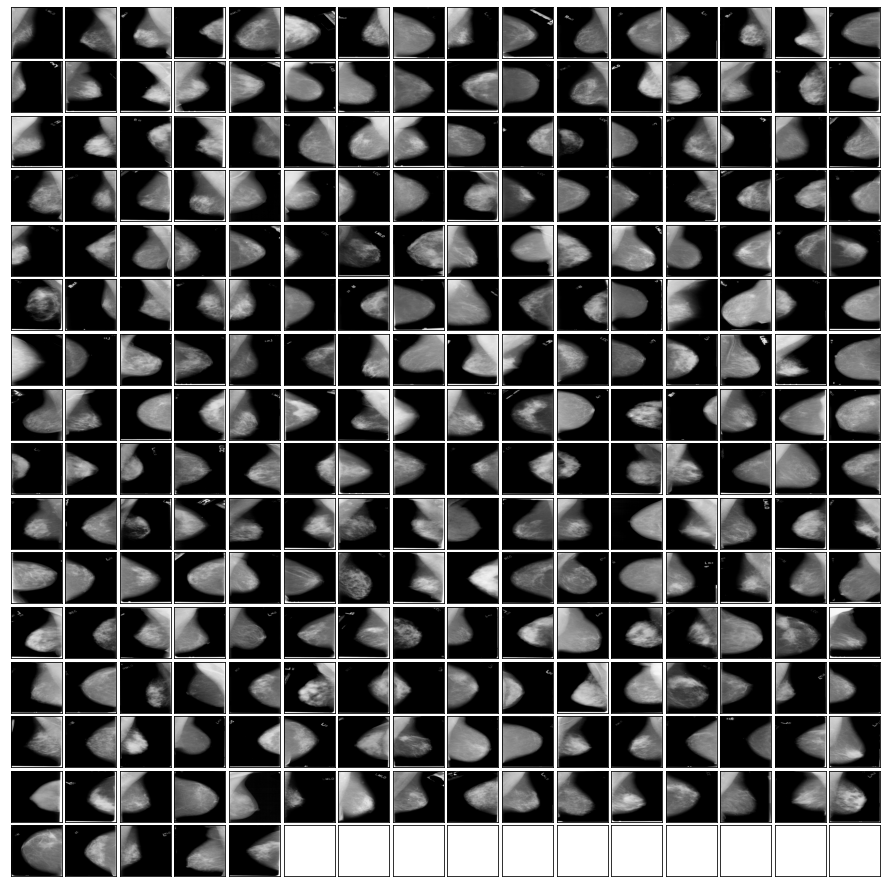

In [ ]:
plotImages(null_rows[null_rows.SeriesDescription=='full mammogram images'].image_path)

100%|██████████| 321/321 [00:36<00:00,  8.86it/s]


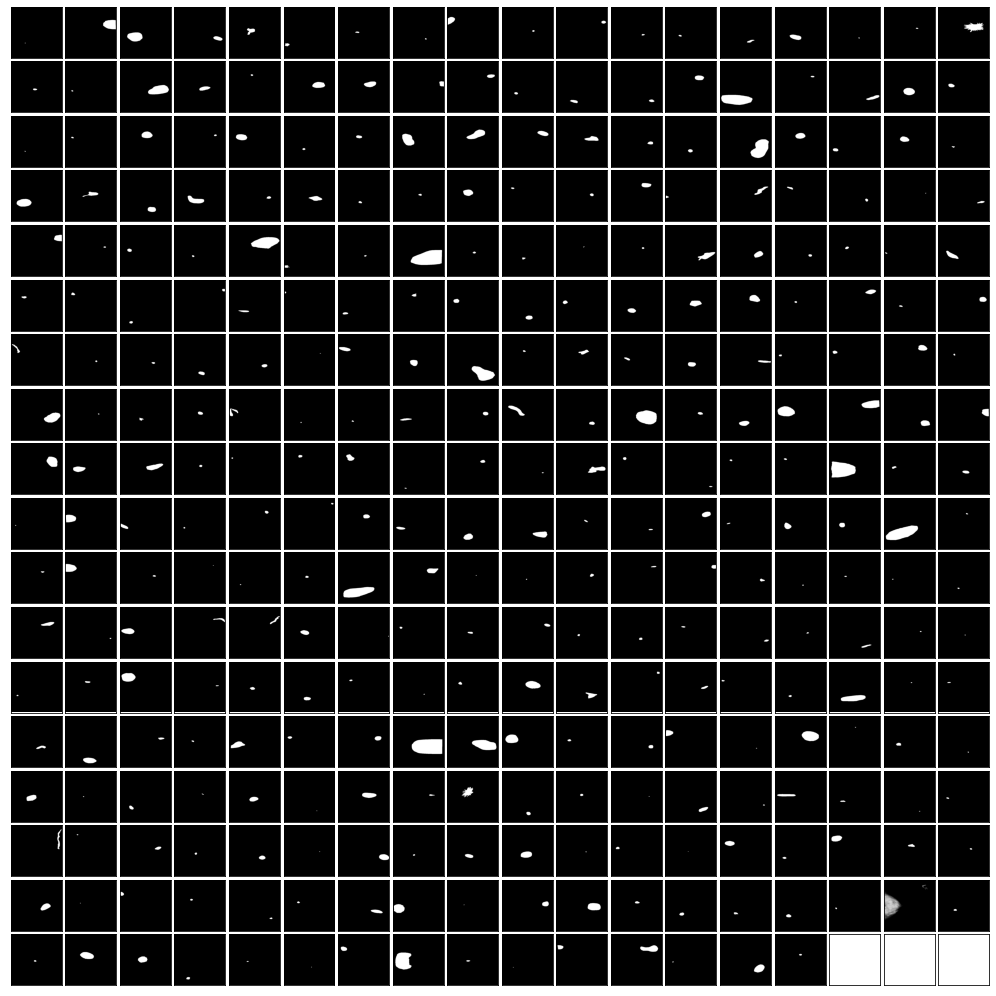

In [ ]:
plotImages(null_rows[null_rows.SeriesDescription=='ROI mask images'].image_path)

**we got only one error of which we will manually change it**

the error as we can see is in the picture number 304 (counting left to right)

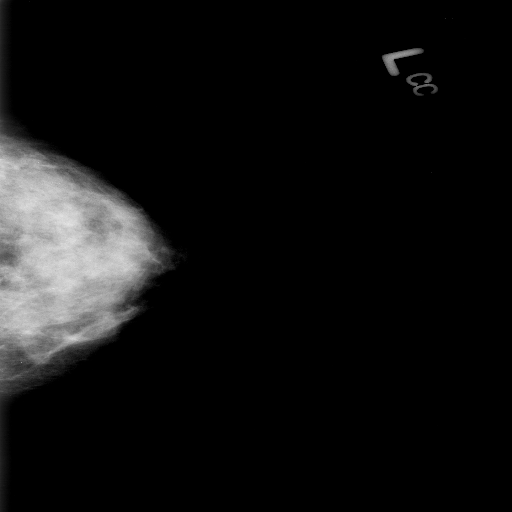

In [ ]:
from google.colab.patches import cv2_imshow
image_path = null_rows[null_rows.SeriesDescription=='ROI mask images'].iloc[304].image_path
img = cv2.resize(cv2.imread(image_path), dsize=(512,512))
cv2_imshow(img)

Now we will manualyy set it to a full mamograme in the dataframe

In [ ]:
null_rows.loc[null_rows['image_path'] == image_path , 'SeriesDescription'] = "full mammogram images"
print(null_rows[null_rows['image_path'] == image_path].SeriesDescription)

9661    full mammogram images
Name: SeriesDescription, dtype: object


/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#Modifying the original dataframes

**modifying dicom_info**

returning the corrected null values to the original dataframe

In [ ]:
dicom_info.update(null_rows)
dicom_info.SeriesDescription.isnull().sum()

0

**New bar chart**

to check the old one see [BCC_Mammography_Dataset_Explore](https://colab.research.google.com/drive/1HfBn6w9E6PyF3AvUGJ1I5hDVJlNKI47N?usp=sharing)



/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='SeriesDescription'>

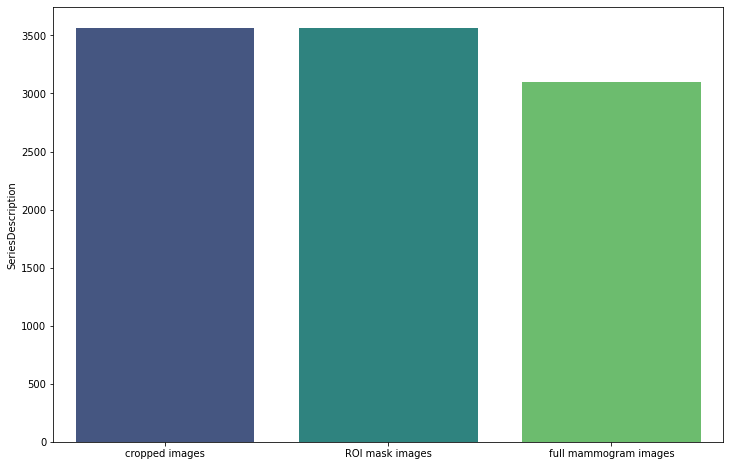

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.barplot(dicom_info.SeriesDescription.value_counts(dropna=False).index, dicom_info.SeriesDescription.value_counts(dropna=False), palette='viridis')

*   the number of cropped images is the same as the ROI mask images
*   but both of them has higher number than full mammogram images 
*   this indicate that most likely some of mammogram images has more than one ROI mask 

Before we proceed will extract the new modified dataframe to our directory, 
we will remove some columns that we won't need

In [ ]:
dicom_info.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','ConversionType','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID','PhotometricInterpretation','PixelRepresentation','SamplesPerPixel','SecondaryCaptureDeviceManufacturer',
                                                 'SecondaryCaptureDeviceManufacturerModelName',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesNumber'],axis =1, inplace=True) 
dicom_info.to_csv('/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM/csv_mod/dicom_info_mod.csv' ,index=False)

**merging calc_case and mass_case**

for the other csv files we will just merg them into one file.


In [ ]:
calc_test = pd.read_csv(f'{DDSM_dir}/csv/calc_case_description_test_set.csv')
calc_train = pd.read_csv(f'{DDSM_dir}/csv/calc_case_description_train_set.csv')
mass_test = pd.read_csv(f'{DDSM_dir}/csv/mass_case_description_test_set.csv')
mass_train = pd.read_csv(f'{DDSM_dir}/csv/mass_case_description_train_set.csv')

mass_case_description = pd.concat([mass_train,mass_test],ignore_index = True)
calc_case_description = pd.concat([calc_train,calc_test],ignore_index = True)

print(mass_case_description.count())
print(calc_case_description.count())

patient_id                 1696
breast_density             1696
left or right breast       1696
image view                 1696
abnormality id             1696
abnormality type           1696
mass shape                 1692
mass margins               1636
assessment                 1696
pathology                  1696
subtlety                   1696
image file path            1696
cropped image file path    1696
ROI mask file path         1696
dtype: int64
patient_id                 1872
breast density             1872
left or right breast       1872
image view                 1872
abnormality id             1872
abnormality type           1872
calc type                  1848
calc distribution          1433
assessment                 1872
pathology                  1872
subtlety                   1872
image file path            1872
cropped image file path    1872
ROI mask file path         1872
dtype: int64


In [ ]:
mass_case_description.to_csv('/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM/csv_mod/mass_case_description.csv')
calc_case_description.to_csv('/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM/csv_mod/calc_case_description.csv')